# Creating a Bell state with pulses on Rigetti's Ankaa-3

Let's create a Bell state program, the `Hello world!` example in quantum computing, with pulses on a Rigetti's device. 

The canonical circuit to generate a Bell pair is constitued of a Hadamard gate on a first qubit followed by a CNOT gate between this qubit and a second qubit. In this notebook, we will realize that creating entangled states requires specific mechanisms that are tightly connected to the hardware type and device architecture. Specifically, we will focus on the native gate set of the Rigetti's device and choose to use specific waveforms and frames that enable native ISWAP gates.

In [1]:
# Use Braket SDK Cost Tracking to estimate the cost to run this example
from braket.tracking import Tracker

t = Tracker().start()

Let's first import a few packages:

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from utils.draw_pulse_sequence import draw_multiple_frames, draw_waveform

from braket.aws import AwsDevice
from braket.circuits import Circuit, QubitSet, circuit
from braket.circuits.gates import ISwap
from braket.devices import Devices

We will use two qubits, `13` and `20`, that are physically connected to each other. We also instantiate a Rigetti device to extract frames and submit circuits.

In [3]:
a = 13
b = 20

device = AwsDevice(Devices.Rigetti.Ankaa3)

## Bell pair with the H, S and ISWAP gates

First we show how to transform our common Bell state circuit into one that contains a ISWAP gate instead of a CNOT gate.

As, CNOT and IWAP only differ by a basis transform, we will add Hadamard gates before and after the ISWAP gate (and an S gate).

In [4]:
bell_pair_with_gates = Circuit().h(a).h(b).iswap(a, b).h(a).h(b).s(b)
print(bell_pair_with_gates)

T   : │  0  │    1    │  2  │  3  │
       ┌───┐ ┌───────┐ ┌───┐       
q13 : ─┤ H ├─┤ ISWAP ├─┤ H ├───────
       └───┘ └───┬───┘ └───┘       
       ┌───┐ ┌───┴───┐ ┌───┐ ┌───┐ 
q20 : ─┤ H ├─┤ ISWAP ├─┤ H ├─┤ S ├─
       └───┘ └───────┘ └───┘ └───┘ 
T   : │  0  │    1    │  2  │  3  │


The circuit is then executed on the Ankaa-3 device and we plot the measurement histogram which hints that we created (up to a global phase) $$\frac{|00\rangle+|11\rangle}{\sqrt{2}}$$ 

We use `disable_qubit_rewiring = True` to be sure that the Bell pair will be created on the specified qubit and not on remapped qubits so we have a fair comparison with the rest of the notebook.

Text(0, 0.5, 'Population')

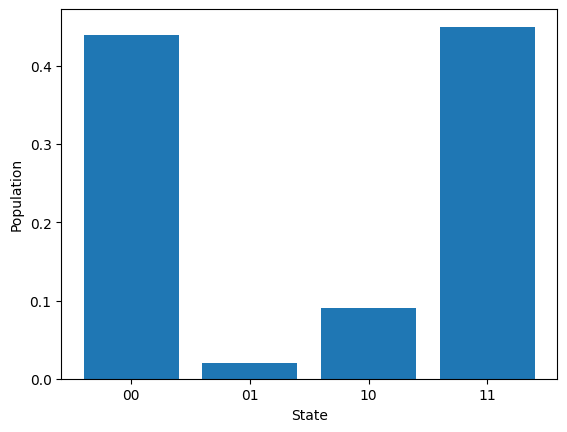

In [5]:
nb_shots = 100
task = device.run(bell_pair_with_gates, shots=nb_shots, disable_qubit_rewiring=True)
counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k] / nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

## Bell pair with the pulse implementation of ISWAP

Since Hadamard and S gates are not native gates on Ankaa-3, we cannot add them to circuits containing pulse sequences. We need to first decompose them into a sequence of native gates. We will use the RX and RZ gates here.

We will annotate this decomposition with `circuit.subroutine` to register this as a custom gate in the circuit allowing easy reuse.

In [6]:
@circuit.subroutine(register=True)
def rigetti_native_h(q0):
    return Circuit().rz(q0, np.pi).rx(q0, np.pi / 2).rz(q0, np.pi / 2).rx(q0, -np.pi / 2)


print(Circuit().rigetti_native_h(a))


@circuit.subroutine(register=True)
def rigetti_native_s(q0):
    # note: non-zero global phase, since rz(pi/2) == exp(-i * pi/4) * s
    return Circuit().rz(q0, np.pi / 2)


print(Circuit().rigetti_native_s(a))

T   : │     0      │     1      │     2      │      3      │
       ┌──────────┐ ┌──────────┐ ┌──────────┐ ┌───────────┐ 
q13 : ─┤ Rz(3.14) ├─┤ Rx(1.57) ├─┤ Rz(1.57) ├─┤ Rx(-1.57) ├─
       └──────────┘ └──────────┘ └──────────┘ └───────────┘ 
T   : │     0      │     1      │     2      │      3      │
T   : │     0      │
       ┌──────────┐ 
q13 : ─┤ Rz(1.57) ├─
       └──────────┘ 
T   : │     0      │


For the ISWAP gate, we will use an arbitrary waveform with parameters (amplitude, rise/fall time, duration) that have been predetermined beforehand. This waveform will be applied on the corresponding `ISWAP` frame. We will retrieve the calibrated waveforms from the device calibrations.

In [7]:
a_b_iswap = device.gate_calibrations.pulse_sequences[ISwap(), QubitSet([a, b])]
a_b_iswap_wfms = a_b_iswap._waveforms
a_b_iswap._waveforms

{'FilteredSquareEnvelope_008': ArbitraryWaveform('id': FilteredSquareEnvelope_008, 'amplitudes': [0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, 0j, (-1.0720124414764172e-05-0j), (-0.0005662734065226937-0j), (-0.00650155396703498-0j), (-0.01957368616633918-0j), (-0.025508966726851462-0j), (-0.026064520008959393-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-0j), (-0.02607524013337416-

To see how they are used in the implementation of the ISWAP gate, we print the corresponding OpenQasm code.

In [8]:
print(a_b_iswap.to_ir())

OPENQASM 3.0;
cal {
    waveform FilteredSquareEnvelope_008 = {0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.0720124414764172e-05, -0.0005662734065226937, -0.00650155396703498, -0.01957368616633918, -0.025508966726851462, -0.026064520008959393, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02607524013337416, -0.02

To draw a waveform, we need to know the frame and the corresponding time separation between each sample. This information is stored in the device capabilities. 

First we retrieve the frame that we will use to create a ISWAP gate between qubit `a` and `b`. The minimum time increment can then be extracted through the corresponding port.

The pulse length will be the product of the number of samples and the minimum time increment. 

In [9]:
waveform_name = list(a_b_iswap._waveforms.keys())[0]

a_b_iswap_wfm = a_b_iswap_wfms[waveform_name]
a_b_iswap_frame = device.frames["Transmon_109_flux_tx_c"]
dt = a_b_iswap_frame.port.dt

print("ISWAP pulse duration:", round(len(a_b_iswap_wfm.amplitudes), 0), "ns")

ISWAP pulse duration: 104 ns


Knowing the frame and the associated time separation, we call plot the waveform and see that it is a rounded square pulse. 

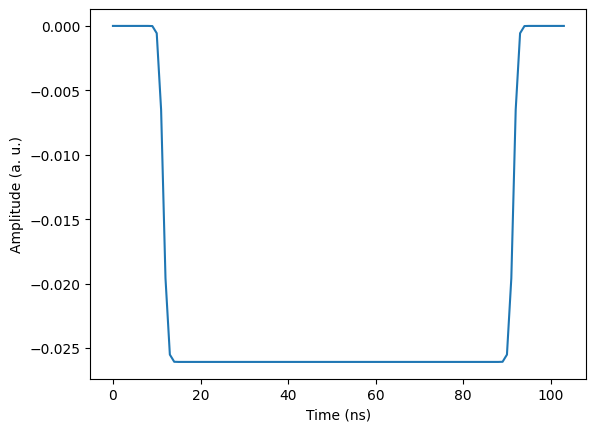

In [10]:
draw_waveform(a_b_iswap_wfm, dt)

Pulse sequences can be exported as time series via the function `to_time_trace` for visualization. This method returns an object that contains all the numerical values of our pulse sequences, and can be used to plot the traces for each frames. In the cell below, we used a local function `draw_multiple_frames` defined in `utils/draw_pulse_sequence.py` that plots the output of `to_time_trace`.

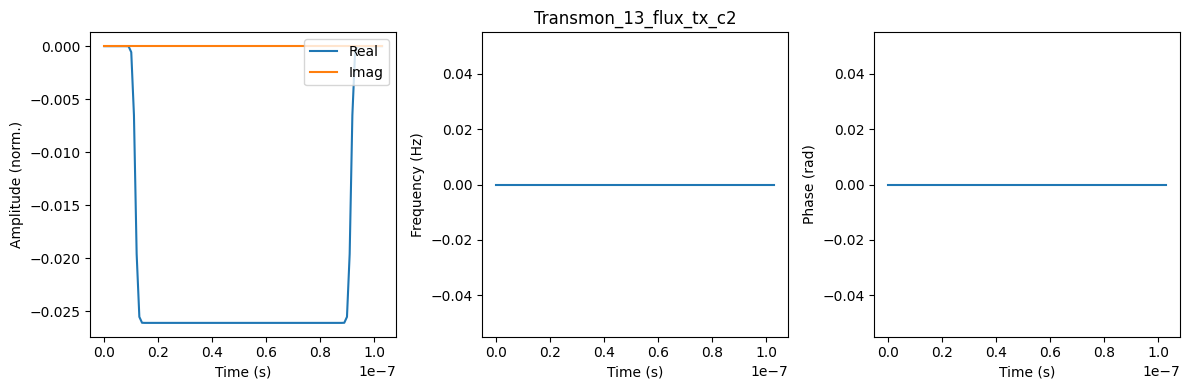

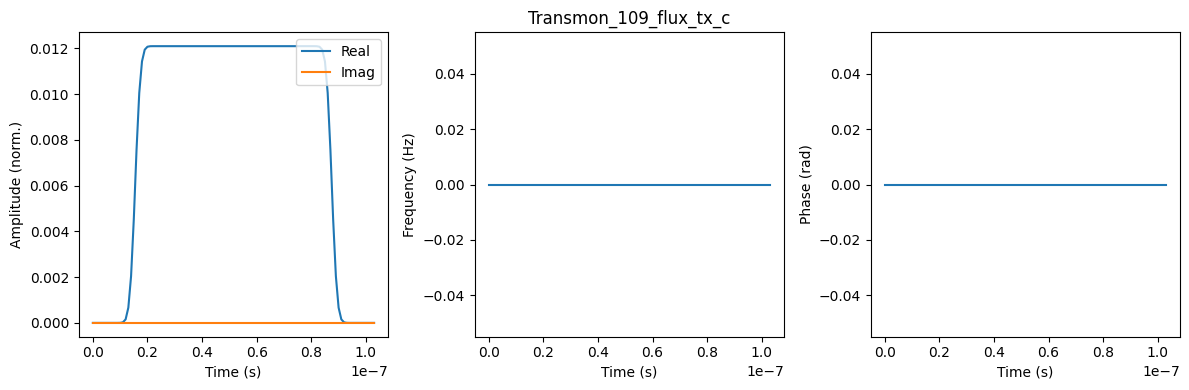

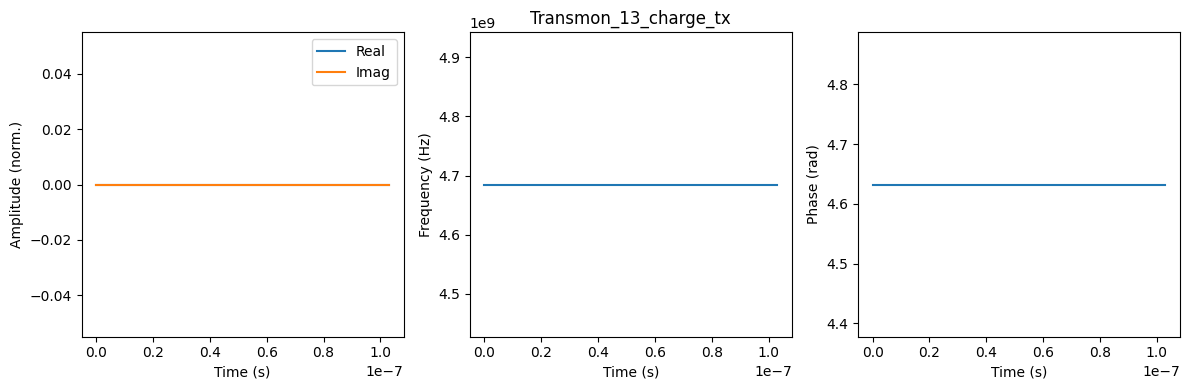

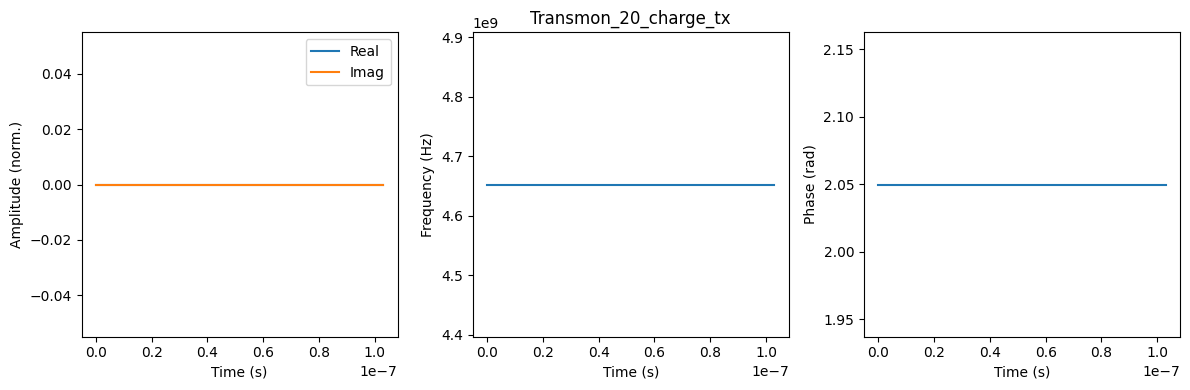

In [11]:
draw_multiple_frames(a_b_iswap)

Finally, we can build our own implementation of the Bell circuit using a `pulse_gate` instruction that encapsulates the pulse sequence into a gate instructions. 

Pulse gates are strictly defined by the pulse sequence and the associated frames. The qubit or a list of qubits provided to `pulse_gate` are for representational purposes.

In [12]:
bell_pair_with_pulse = (
    Circuit()
    .rigetti_native_h(a)
    .rigetti_native_h(b)
    .pulse_gate([a, b], a_b_iswap)
    .rigetti_native_h(a)
    .rigetti_native_h(b)
    .rigetti_native_s(b)
)
print(bell_pair_with_pulse)

T   : │     0      │     1      │     2      │      3      │  4   │     5      │     6      │     7      │      8      │     9      │
       ┌──────────┐ ┌──────────┐ ┌──────────┐ ┌───────────┐ ┌────┐ ┌──────────┐ ┌──────────┐ ┌──────────┐ ┌───────────┐              
q13 : ─┤ Rz(3.14) ├─┤ Rx(1.57) ├─┤ Rz(1.57) ├─┤ Rx(-1.57) ├─┤ PG ├─┤ Rz(3.14) ├─┤ Rx(1.57) ├─┤ Rz(1.57) ├─┤ Rx(-1.57) ├──────────────
       └──────────┘ └──────────┘ └──────────┘ └───────────┘ └─┬──┘ └──────────┘ └──────────┘ └──────────┘ └───────────┘              
       ┌──────────┐ ┌──────────┐ ┌──────────┐ ┌───────────┐ ┌─┴──┐ ┌──────────┐ ┌──────────┐ ┌──────────┐ ┌───────────┐ ┌──────────┐ 
q20 : ─┤ Rz(3.14) ├─┤ Rx(1.57) ├─┤ Rz(1.57) ├─┤ Rx(-1.57) ├─┤ PG ├─┤ Rz(3.14) ├─┤ Rx(1.57) ├─┤ Rz(1.57) ├─┤ Rx(-1.57) ├─┤ Rz(1.57) ├─
       └──────────┘ └──────────┘ └──────────┘ └───────────┘ └────┘ └──────────┘ └──────────┘ └──────────┘ └───────────┘ └──────────┘ 
T   : │     0      │     1      │     2      │      3      │  

Circuits with embedded pulse sequences can be executed normally.

As pulse sequences are inherently hardware dependent, since the timings and strength of the waveforms are tuned to be optimal for the frame they are played on, you can only use pulse gates with the flag `disable_qubit_rewiring=True` that prevents any compiler to remap qubits. The Amazon Braket SDK toggles automatically the flag when it detects that pulse sequences are embedded in a circuit.

Text(0, 0.5, 'Population')

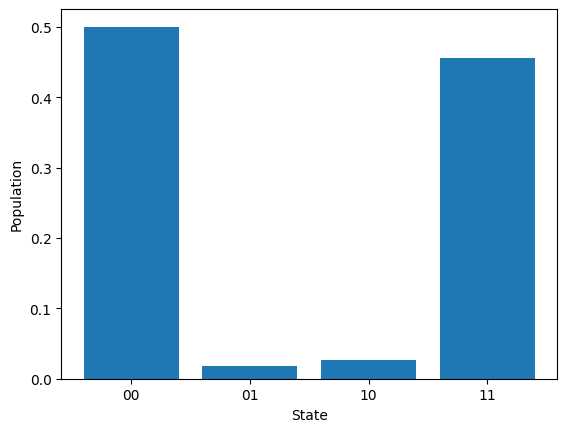

In [13]:
nb_shots = 500
task = device.run(bell_pair_with_pulse, shots=nb_shots, disable_qubit_rewiring=True)
counts = task.result().measurement_counts
plt.bar(sorted(counts), [counts[k] / nb_shots for k in sorted(counts)])
plt.xlabel("State")
plt.ylabel("Population")

In [14]:
print("Quantum Task Summary")
print(t.quantum_tasks_statistics())
print(
    "Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).",
)
print(
    f"Estimated cost to run this example: {t.qpu_tasks_cost() + t.simulator_tasks_cost():.3f} USD",
)

Quantum Task Summary
{<_Rigetti.Ankaa3: 'arn:aws:braket:us-west-1::device/qpu/rigetti/Ankaa-3'>: {'shots': 600, 'tasks': {'COMPLETED': 2}}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run this example: 1.140 USD
